In [ ]:
import requests
import pandas as pd
import time

# -----------------------------------
# Settings
# -----------------------------------
OUT_FILE = r"D:\Project\glp1_ci_project_2020_2025\data\processed\pipeline_raw.csv"

# Keywords for GLP-1 / GIP / dual / triple agonist universe
KEYWORDS = [
    "semaglutide",
    "tirzepatide",
    "liraglutide",
    "dulaglutide",
    "exenatide",
    "retatrutide",
    "triple agonist",
    "dual agonist",
    "GLP-1",
    "GIP"
]

BASE_URL = "https://clinicaltrials.gov/api/v2/studies"

def fetch_trials_for_term(term, page_size=100, max_pages=5):
    records = []
    cursor = None

    for _ in range(max_pages):
        params = {
            "query.term": term,
            "pageSize": page_size,
            "format": "json"
        }
        if cursor:
            params["pageToken"] = cursor

        resp = requests.get(BASE_URL, params=params)
        if resp.status_code != 200:
            print(f"Error {resp.status_code} for term {term}")
            break

        data = resp.json()
        studies = data.get("studies", [])
        if not studies:
            break

        for s in studies:
            ps = s.get("protocolSection", {})
            idm = ps.get("identificationModule", {})
            dm = ps.get("designModule", {})
            sm = ps.get("statusModule", {})
            cm = ps.get("conditionsModule", {})
            am = ps.get("armsInterventionsModule", {})
            scm = ps.get("sponsorCollaboratorsModule", {})

            nct_id = idm.get("nctId", "")
            title = idm.get("briefTitle", "")

            phase_list = dm.get("phases", [])
            phase = ", ".join(phase_list) if isinstance(phase_list, list) else phase_list

            status = sm.get("overallStatus", "")

            conditions = cm.get("conditions", [])
            conditions_str = ", ".join(conditions) if isinstance(conditions, list) else conditions

            interventions = am.get("interventions", []) or []
            int_names = []
            int_types = []
            for inv in interventions:
                int_names.append(inv.get("name", ""))
                int_types.append(inv.get("type", ""))

            sponsor = scm.get("leadSponsor", {}).get("name", "")

            records.append({
                "search_term": term,
                "nct_id": nct_id,
                "study_title": title,
                "phase": phase,
                "status": status,
                "intervention_name": "; ".join(int_names),
                "intervention_type": "; ".join(int_types),
                "mechanism_hint": term,
                "sponsor": sponsor,
                "conditions": conditions_str,
                "start_date": sm.get("startDateStruct", {}).get("date", ""),
                "primary_completion_date": sm.get("primaryCompletionDateStruct", {}).get("date", ""),
                "source_link": f"https://clinicaltrials.gov/study/{nct_id}"
            })

        cursor = data.get("nextPageToken", None)
        if not cursor:
            break

        time.sleep(0.2)

    return records

all_records = []

for term in KEYWORDS:
    print(f"🔍 Fetching trials for term: {term}")
    term_records = fetch_trials_for_term(term)
    print(f"  → {len(term_records)} records")
    all_records.extend(term_records)

df = pd.DataFrame(all_records)

# Drop duplicates on NCT ID
df = df.drop_duplicates(subset=["nct_id"])

df.to_csv(OUT_FILE, index=False)
print(f"\n✅ Saved pipeline_raw.csv with {len(df)} unique trials")
print(f"📁 {OUT_FILE}")


In [1]:
import pandas as pd

df = pd.read_csv(r"D:\Project\glp1_ci_project_2020_2025\data\processed\pipeline_raw.csv")

df.head()


,nct_id,study_title,phase,status,intervention_name,intervention_type,mechanism_class,sponsor,conditions,start_date,primary_completion_date,locations,source_link,notes
0,NCT04215328,Facilitated Release of Endogenous Enterokines,['NA'],COMPLETED,"Mixed-Meal, Electrolyte Solution","DIETARY_SUPPLEMENT, DIETARY_SUPPLEMENT",GLP-1,University of Southern California,"['Diabetes Mellitus, Type 2']",2014-11-01,2019-02-28,NaN,https://clinicaltrials.gov/study/NCT04215328,NaN
1,NCT06498063,The Underlying Mechanisms Regarding the Effect...,['NA'],RECRUITING,"Glucagon, Placebo, Glucagon and exendin 9-39","OTHER, OTHER, OTHER",GLP-1,Ali Asmar,['Kidney Diseases'],2024-02-20,2025-03-28,NaN,https://clinicaltrials.gov/study/NCT06498063,NaN
2,NCT07187830,Visceral Adipose Tissue and Liver Changes Asso...,NaN,NOT_YET_RECRUITING,NaN,NaN,GLP-1,University of Alberta,"['Chronic Kidney Disease in Type 2 Diabetes', ...",2025-12-15,2027-12-15,NaN,https://clinicaltrials.gov/study/NCT07187830,NaN
3,NCT00211536,Study Comparing Effectiveness of Intraperitone...,['PHASE3'],COMPLETED,Medtronic MiniMed Implantable Pump Human Recom...,"DRUG, DEVICE, DRUG",GLP-1,Medtronic Diabetes,['Type 1 Diabetes'],2002-06,2004-08,NaN,https://clinicaltrials.gov/study/NCT00211536,NaN
4,NCT02284009,Albiglutide Versus Placebo in Insulin-treated ...,['PHASE2'],COMPLETED,"Albiglutide weekly injection, Placebo weekly i...","BIOLOGICAL, BIOLOGICAL, BIOLOGICAL",GLP-1,GlaxoSmithKline,"['Diabetes Mellitus, Type 1']",2014-10-10,2017-10-18,NaN,https://clinicaltrials.gov/study/NCT02284009,NaN


In [2]:
def normalize_phase(phase):
    if pd.isna(phase):
        return "Unknown"
    p = phase.lower()
    if "phase 1" in p and "phase 2" in p:
        return "Phase 1/2"
    if "phase 2" in p and "phase 3" in p:
        return "Phase 2/3"
    if "early" in p:
        return "Phase 1"
    if "phase 1" in p:
        return "Phase 1"
    if "phase 2" in p:
        return "Phase 2"
    if "phase 3" in p:
        return "Phase 3"
    if "phase 4" in p:
        return "Phase 4"
    return "Unknown"

df["phase_clean"] = df["phase"].apply(normalize_phase)

df["phase_clean"].value_counts()


phase_clean
Unknown    1436
Phase 1      19
Name: count, dtype: int64

In [3]:
def classify_mechanism(intervention):
    if pd.isna(intervention):
        return "Unknown"
    text = intervention.lower()
    if "triple" in text:
        return "Triple agonist"
    if "dual" in text or ("gip" in text and "glp" in text):
        return "Dual agonist"
    if "gip" in text:
        return "GIP agonist"
    if "glp" in text:
        return "GLP-1 agonist"
    return "Other"

df["mechanism_class"] = df["intervention_name"].apply(classify_mechanism)

df["mechanism_class"].value_counts()


mechanism_class
Other             1361
GLP-1 agonist       38
Unknown             33
Dual agonist        11
GIP agonist          6
Triple agonist       6
Name: count, dtype: int64

In [4]:
df["sponsor"].value_counts().head(10)


sponsor
Eli Lilly and Company                        159
Novo Nordisk A/S                             141
AstraZeneca                                   62
GlaxoSmithKline                               38
University Hospital, Gentofte, Copenhagen     22
Brigham and Women's Hospital                  15
Boehringer Ingelheim                          14
University of Copenhagen                      14
Sanofi                                        13
Merck Sharp & Dohme LLC                       13
Name: count, dtype: int64

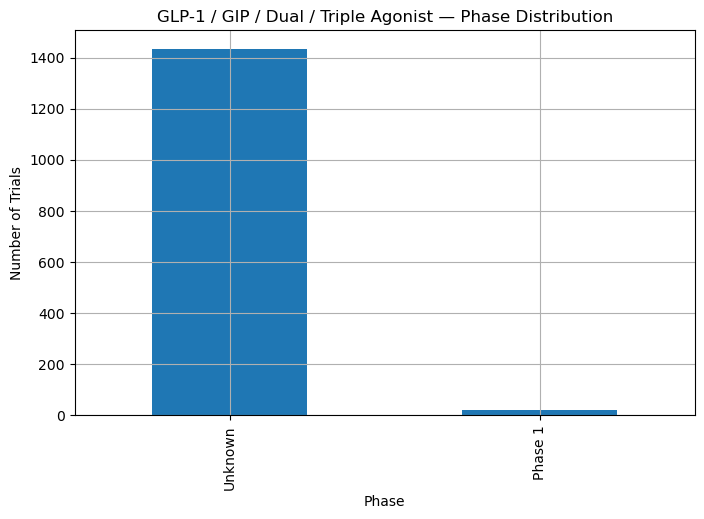

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
df["phase_clean"].value_counts().plot(kind="bar")
plt.title("GLP-1 / GIP / Dual / Triple Agonist — Phase Distribution")
plt.xlabel("Phase")
plt.ylabel("Number of Trials")
plt.grid(True)
plt.show()


In [6]:
# Select only useful cleaned columns for final dataset

pipeline_clean = df[[
    "nct_id",
    "study_title",
    "phase_clean",
    "status",
    "intervention_name",
    "intervention_type",
    "mechanism_class",
    "sponsor",
    "conditions",
    "start_date",
    "primary_completion_date",
    "source_link"
]].copy()

# Save cleaned file
OUT_CLEAN = r"D:\Project\glp1_ci_project_2020_2025\data\processed\pipeline_clean.csv"
pipeline_clean.to_csv(OUT_CLEAN, index=False)

OUT_CLEAN


'D:\\Project\\glp1_ci_project_2020_2025\\data\\processed\\pipeline_clean.csv'